<a href="https://colab.research.google.com/github/manideep137/EAI-6000/blob/master/Assignment_3_Street_View_House_Numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Street View House Numbers Dataset


The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 0, '9' has label 8 and '0' has label 9. Your goal is to build a model that recognizes the correct digit.

In [0]:
%matplotlib inline
!pip install openml # Uncomment to run in Google Colab
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import time

     |████████████████████████████████| 163kB 2.8MB/s 
  Created wheel for openml: filename=openml-0.10.2-cp36-none-any.whl size=190318 sha256=ea59dc0e55f123171b113762dfafe2c30231f6cd88d3dee54008eca1eb6831a7
  Stored in directory: /root/.cache/pip/wheels/71/ec/5f/aaad9e184680b0b8f1a02ff0ec640cace5adf5bff7bb0af1b4
  Created wheel for liac-arff: filename=liac_arff-2.4.0-cp36-none-any.whl size=13335 sha256=5d564d0972bfb303d10168e84044e308cd44532d8b4682f5e14a1e51025e1921
  Stored in directory: /root/.cache/pip/wheels/d1/6a/e7/529dc54d76ecede4346164a09ae3168df358945612710f5203
Successfully built openml liac-arff


In [0]:
# Download Streetview data. Takes a while to download (5-10 min).
SVHN = oml.datasets.get_dataset(41081)
X, y, cats, attrs = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

In [0]:
# To save time, you can save the dataset to a Google drive, and load it quickly later
from google.colab import drive
drive.mount('/content/drive')

with open("drive/My Drive/SVHN.pkl", "wb") as f:
    pickle.dump(X, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y, f, protocol=pickle.HIGHEST_PROTOCOL)   
    pickle.dump(cats, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(attrs, f, protocol=pickle.HIGHEST_PROTOCOL)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# (Uncomment to) Load SVHN dataset from Google drive
 from google.colab import drive
 drive.mount('/content/drive')

 with open("drive/My Drive/SVHN.pkl", "rb") as f:
     X = pickle.load(f)
     y = pickle.load(f)
     cats = pickle.load(f)
     attrs = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### What is the shape of the image data X? How many images are there? Explain why each image has 3072 values.

In [0]:
X.shape

(99289, 3072)

99289 Images
because each image is 312-by-32 RGB(3 bits),which means 32 times 32 times 3 =3072 values

### You can use the following function to plot the first 10 images to get a sense of the data.

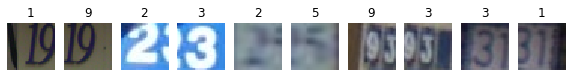

In [0]:
# Plots image. Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    if grayscale:
        [ax.imshow(X[n].reshape(32, 32)/255, cmap='gray')
         for n,ax in enumerate(axes)]
    else:
        [ax.imshow(X[n].reshape(32, 32, 3)/255) for n,ax in enumerate(axes)]
    [ax.set_title((y[n]+1)) for n,ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]
plot_images(X[0:10], y[0:10]);

### Next, we will convert the images to greyscale and normalize the data to fall within the range 0 to 1. Plot the first 10 images to verify that the conversion worked.

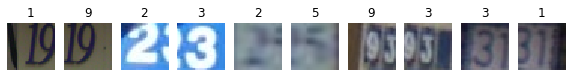

In [0]:
# Plots image. Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=True):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    if grayscale:
        [ax.imshow(X[n].reshape(32, 32,3)/255, cmap='gray') for n,ax in enumerate(axes)]
    else:
        [ax.imshow(X[n].reshape(32, 32, 3)/255) for n,ax in enumerate(axes)]
    [ax.set_title((y[n]+1)) for n,ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]
plot_images(X[0:10], y[0:10]);

### Evaluate different linear models

1. To save time, use a stratified 1% subsample of the data. Plot the distribution of the classes (as a histogram) for both the original data and the subsample to verify this was done correctly. (hint: a quick way to do it is to borrow the stratify option with sklearn.model_selection.train_test_split)
2. Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM on this sample, using their default hyperparameter settings. Use cross-validation with 3 folds, output the training accuracy and test accuracy (feel free to reuse code from past assignments). [Time](https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution) how long execution takes.
3. Discuss the results. Are they what you expected? Are the models over/underfitting? What should be done to improve the results?
4. Now evaluate the same models using 3% of the data. Discuss the results. Is the run time what you expect? Which models perform better or worse than the 1% training? How can you explain this in terms of underfitting/overfitting?

### Evaluate feed-forward neural network

Counter-intuitively, even though the linear models above are slow, you can easily train the small neural network below with 100% of the data in very little time. Learn more about Google Colab if you're curious: https://research.google.com/colaboratory/faq.html 
1. Train a neural network on the full (100%) data. Start with a single hidden layer with 256 neurons, and the same output layer as this week's Fashion-MNIST lab. Evaluate the accuracy using an 80/20 train test split. How does it compare with the linear models?
2. Plot the confusion matrix. Which digits are often confused with each other? 
3. Plot the first 15 correctly classified examples and the first 15 incorrectly classified examples, along with a bar plot of the predictions array. You can use the provided plotting functions. What sort of errors do you see? Are these indeed 'hard' examples that are easy to get wrong?


In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label+1,
                                100*np.max(predictions_array),
                                true_label+1),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks([1,2,3,4,5,6,7,8,9,0],rotation=90)
  plt.yticks([])
  thisplot = plt.bar([1,2,3,4,5,6,7,8,9,0], predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Bonus challenge: 
Can you improve the model performance from this first Keras model?
If you wonder about how researchers get to 98% accuracy, here is a list of papers :)
https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#5356484e 